In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import numpy as np
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt

from isegm.utils import vis, exp

from isegm.inference import utils

cfg = exp.load_config_file('config.yml', return_edict=True)
plt.rcParams['text.usetex'] = False

No CUDA runtime is found, using CUDA_HOME='/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/cuda-11.7.0-hfqzohhoijx3mhqdh2w3mvycmhbrcner'


# View IoU scores

In [2]:
def get_run_results(run_path):
    
    res = []
    
    
    if 'multirun' in run_path:
        for dir in os.listdir(run_path):
            if os.path.isdir(os.path.join(run_path, dir)):
                run_dir = os.path.join(run_path, dir)
                with open(os.path.join(run_dir, '.hydra', 'overrides.yaml')) as f:
                    run_cfg = f.readlines()
                summary = pd.read_csv(os.path.join(run_dir, 'summary.csv'))
                res.append((run_cfg, summary))
    else:
        run_dir = run_path
        with open(os.path.join(run_dir, '.hydra', 'overrides.yaml')) as f:
            run_cfg = f.readlines()
        summary = pd.read_csv(os.path.join(run_dir, 'summary.csv'))
        res.append((run_cfg, summary))      
        
    cfgs = [r[0] for r in res]
    string_count = {}
    
    for array in cfgs:
        for string in array:
            if string in string_count:
                string_count[string] += 1
            else:
                string_count[string] = 1
    
    configs = []
    for array in cfgs:
        unique_array = [string for string in array if string_count[string] == 1]
        configs.append(unique_array)
        
    configs = [[line.split(' ')[1].strip() for line in c] for c in configs]
    configs = ['_'.join(c) for c in configs]
    
    res = [(c, r[1]) for c, r in zip(configs, res)] if len(configs) > 1 else [(r[0][-1].split('=')[1].strip(), r[1]) for r in res]
    
    return res

In [3]:
lidc_small = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/LIDC_SMALL'
kits_small = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/KITS23_SMALL'
lits_small = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/LITS_SMALL'
md_panc_small = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/MD_PANC_SMALL'
combined_small = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/COMBINED_SMALL'

lidc_big = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/LIDC_BIG'
kits_big = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/KITS23_BIG'
lits_big = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/LITS_BIG'
md_panc_big = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/MD_PANC_FULL'
combined_big = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/COMBINED_FULL'

kits_transfer = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/KITS23_TRANSFER'
md_panc_transfer = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/MD_PANC_TRANSFER'
combined_to_lidc_transfer = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/COMBINED_TO_LIDC_TRANSFER'

kits_transfer_small = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/KITS23_TRANSFER_SMALL'
md_panc_transfer_small = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/MD_PANC_TRANSFER_SMALL'
combined_to_lidc_transfer_small = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/COMBINED_TO_LIDC_TRANSFER_SMALL'

In [4]:
eval_results = get_run_results(kits_transfer)
print([r[0] for r in eval_results])
title_keys = ['Progressive mode after 10 clicks', 'Progressive mode from the start', 'No Progressive mode']
if len(eval_results) == 1:
    title_keys = ['']

['KITS23_TRANSFER']


In [5]:
def format_dataset_name(name):
    if 'TUMOURS_' in name:
        name = name.replace('TUMOURS_', '')
    
    if name.endswith('_TEST'):
        name = name[:-5]
    else:
        name = name + '_DO_NOT_USE'
        return name    
    
    if name.endswith('_FULL'):
        name = name[:-5]
    # else:
    #     name = name + '_{Small}'
    
    # underscore_indices = [i for i, c in enumerate(name) if c == '_'][:-1]
    underscore_indices = [i for i, c in enumerate(name) if c == '_']
    for i in underscore_indices:
        name = name[:i] + ' ' + name[i+1:]
    
    return name

def format_model_name(name):
    name = name.replace('UnetPlusPlus', 'Unet++')
    name = name.replace('Static disks', '')
    name = name.replace('Static Disks', '')
    name = name.replace(' Dynamic disks', '_{Dynamic}')
    name = name.split('  ')[0]
    return name

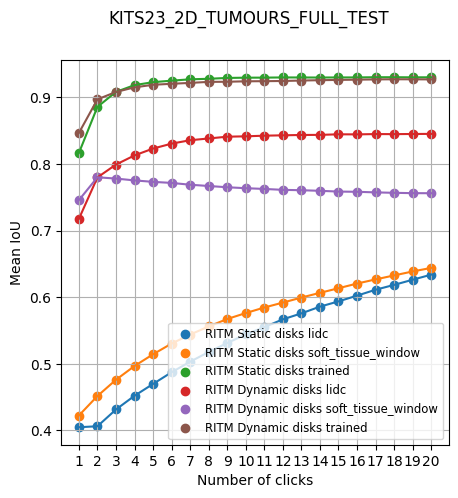

In [6]:
def visualise_dataset_summary(eval_results, title_keys):
    clicks = np.arange(1, 21)
    
    sample_run = eval_results[0][1]
    dataset_names = sample_run.iloc[:, 1].values
    
    iou_col_names = [f'iou_{i+1}_clicks' for i in range(20)]
    
    unique_datasets = np.unique(dataset_names)
    unique_datasets.sort()
    
    for dataset_name in unique_datasets:
        fig, ax = plt.subplots(1, len(title_keys), figsize=(len(title_keys)*5, 5), squeeze=False)
        # fig.suptitle(f'LIDC-2D model on KITS-2D-TUMOURS')
        fig.suptitle(f'{dataset_name}')
        
        for idx, (_, run) in enumerate(eval_results):
            rows = list(run.iterrows())
            for row_idx, row in enumerate(rows):
                if row[1]['dataset'] == dataset_name:
                    iou_values = row[1][iou_col_names].values
                    model_name = row[1]['model']
                    # model_name = model_name.replace('big_dataset', '')
                    # model_name = model_name.replace('big dataset', '')
                    # model_name = model_name.replace('ritm_standard', 'Static disks')
                    # model_name = model_name.replace('dynamic_clicks', 'Dynamic disks')
                    # model_name = model_name.replace('Static disks', 'Static disks')
                    # model_name = model_name.replace('dynamic clicks', 'Dynamic disks')
                    # model_name = model_name.replace('BceDice loss', '')
                    # model_name = model_name.replace('NormFocalLoss', '')
                    # model_name = model_name.replace('FocalClick static ', '')
                    # model_name = model_name.replace('ritm_standard aug', 'RITM augmentations')
                    # model_name = model_name.replace('focalclick_standard aug', 'FocalClick augmentations')
                    # model_name = model_name.replace('target_crop aug', 'Target Crop augmentations')
                    # model_name = model_name.replace('Dynamic disks min', 'FocalClick Dynamic disks min')
                    # if row_idx == 0:
                    #     model_name = model_name + 'LIDC training and windowing'
                    # if row_idx == 1:
                    #     model_name = model_name + 'LIDC training KITS windowing'
                    # if row_idx == 2:
                    #     model_name = model_name + 'KITS training and windowing'
                    ax[0, idx].plot(clicks, iou_values)
                    ax[0, idx].scatter(clicks, iou_values, label=model_name)
            ax[0, idx].set_title(title_keys[idx])
            ax[0, idx].set_xlabel('Number of clicks')
            ax[0, idx].set_ylabel('Mean IoU')
            ax[0, idx].set_xticks(clicks)
            ax[0, idx].grid()
            ax[0, idx].legend(loc='lower right', fontsize='small')


visualise_dataset_summary(eval_results, title_keys)

In [8]:
import seaborn as sns

# # Setting a pastel color palette
# sns.set(style="whitegrid", palette="pastel")

In [ ]:
import os
import csv
import pandas as pd

def extract_mean_iou(input_dirs, output_file):
    results = []

    for input_dir in input_dirs:
        for root, _, files in os.walk(input_dir):
            for file in files:
                if file.endswith(".csv"):
                    file_path = os.path.join(root, file)
                    model_name, dataset_name = file.split('-')
                    dataset_name = dataset_name.replace('.csv', '')
                    
                    # Read the CSV file
                    df = pd.read_csv(file_path)
                    
                    # Calculate the mean IoU after 1 click
                    mean_iou_1_click = df['iou_1_clicks'].mean()
                    
                    # Store the result
                    results.append({
                        'model': model_name,
                        'dataset': dataset_name,
                        'mean_iou_1_click': mean_iou_1_click
                    })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Generate the output CSV with mean IoUs per model per dataset
    summary_df = results_df.groupby(['model', 'dataset']).mean().reset_index()
    summary_df.to_csv(output_file, index=False)


input_dirs = [
    '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/TRANSFER_LIDC/metrics',
    '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/TRANSFER_KITS',
    '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/TRANSFER_LITS',
    '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/TRANSFER_MD_PANC'
    '/gpfs/space/projects/PerkinElmer/donatasv_experiments/repos/ClickSEG/outputs/evaluation/final_results/TRANSFER_COMBINED/metrics',
]
output_file = 'mean_iou_summary.csv'

# Extract and save the mean IoU summary
extract_mean_iou(input_dirs, output_file)


In [27]:
import pandas as pd
from tabulate import tabulate

import pandas as pd

def generate_latex_table(filename):
    # Read the CSV file
    df = pd.read_csv(filename)
    
    # Add a new column for the base model type based on the 'model' column
    df['Base Model'] = df['model'].apply(lambda x: 'Static' if 'Static' in x else 'Dynamic')

    # Manually create a new DataFrame to format the LaTeX table
    models = {'Static': {}, 'Dynamic': {}}

    # Iterate over rows to populate the dictionary
    for _, row in df.iterrows():
        base_model = row['Base Model']
        iou_1_click = row['iou_1_clicks']
        if 'lidc' in row['model'] and 'soft_tissue_window' not in row['model']:
            models[base_model]['Trained on LIDC'] = iou_1_click
        elif 'soft_tissue_window' in row['model']:
            models[base_model]['Trained on LIDC w/ Soft Tissue'] = iou_1_click
        elif 'trained' in row['model']:
            models[base_model]['Trained on Dataset (Self)'] = iou_1_click

    # Create a LaTeX table manually
    latex_str = "\\begin{tabular}{lccc}\n"
    latex_str += "\\toprule\n"
    latex_str += "Model & Trained on LIDC & Trained on LIDC w/ Soft Tissue & Trained on Dataset (Self) \\\\\n"
    latex_str += "\\midrule\n"
    for model, vals in models.items():
        trained_lidc = f"{vals.get('Trained on LIDC', '--'):.3f}" if 'Trained on LIDC' in vals else '--'
        trained_soft_tissue = f"{vals.get('Trained on LIDC w/ Soft Tissue', '--'):.3f}" if 'Trained on LIDC w/ Soft Tissue' in vals else '--'
        trained_self = f"{vals.get('Trained on Dataset (Self)', '--'):.3f}" if 'Trained on Dataset (Self)' in vals else '--'
        latex_str += f"{model} & {trained_lidc} & {trained_soft_tissue} & {trained_self} \\\\\n"
    latex_str += "\\bottomrule\n"
    latex_str += "\\end{tabular}"

    # Print the LaTeX table
    print(latex_str)

    
generate_latex_table(f'{kits_transfer}/summary.csv')

\begin{tabular}{lccc}
\toprule
Model & Trained on LIDC & Trained on LIDC w/ Soft Tissue & Trained on Dataset (Self) \\
\midrule
Static & 0.405 & 0.422 & 0.816 \\
Dynamic & 0.718 & 0.746 & 0.847 \\
\bottomrule
\end{tabular}


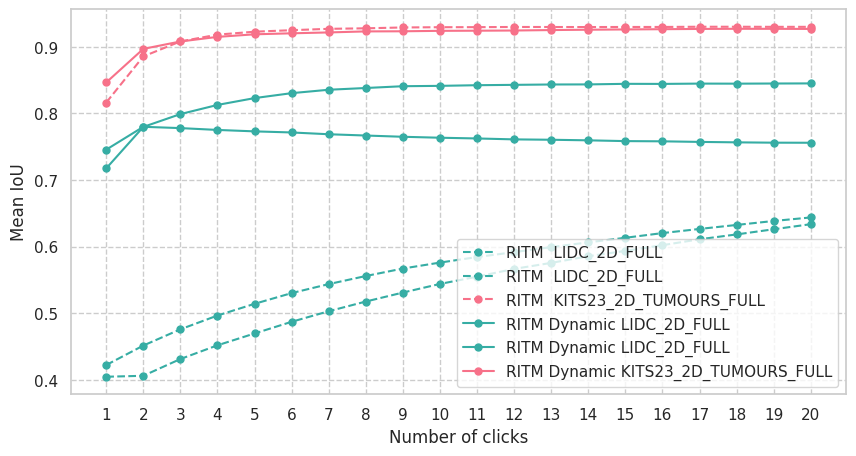

In [7]:
def extract_base_model_name(model_name):
    # Strips suffix to unify static and dynamic versions of the same model
    return model_name.replace(' Static disks', '').replace(' Dynamic disks', '')

def visualise_dataset_summary(eval_results, title_keys):
    sns.set(style="whitegrid")  # Set the visual style

    clicks = np.arange(1, 21)
    
    sample_run = eval_results[0][1]
    dataset_names = sample_run.iloc[:, 1].values
    
    iou_col_names = [f'iou_{i+1}_clicks' for i in range(20)]
    
    unique_datasets = np.unique(dataset_names)
    unique_datasets.sort()
    
    for dataset_name in unique_datasets:
        fig, ax = plt.subplots(1, len(title_keys), figsize=(len(title_keys)*10, 5), squeeze=False)
        title_dataset_name = format_dataset_name(dataset_name)
        # fig.suptitle(title_dataset_name)
        
        for idx, (_, run) in enumerate(eval_results):
            # Create a color palette based on the base model names
            base_models = [extract_base_model_name(model) for model in run['model'].unique()]
            unique_base_models = sorted(set(base_models))
            color_palette = sns.color_palette("husl", n_colors=len(unique_base_models))
            model_color_map = {model: color_palette[i] for i, model in enumerate(unique_base_models)}

            rows = list(run.iterrows())
            rows = reversed(sorted(rows, key=lambda x: x[1]['model']))
            for row_idx, row in rows:
                if row['dataset'] == dataset_name:
                    iou_values = row[iou_col_names].values
                    model_name = row['model']
                    if model_name == 'UnetPlusPlus Static disks':
                        continue
                    base_model_name = extract_base_model_name(model_name)
                    color = model_color_map[base_model_name]
                    linestyle = '--' if "Static" in model_name else '-'
                    ax[0, idx].plot(clicks, iou_values, marker='o', markersize=5, linestyle=linestyle, color=color, label=model_name.replace('Static disks', '').replace('Dynamic disks', 'Dynamic'))
            
            ax[0, idx].set_xlabel('Number of clicks')
            ax[0, idx].set_ylabel('Mean IoU')
            ax[0, idx].set_xticks(clicks)
            ax[0, idx].legend(frameon=True, loc='lower right')
            ax[0, idx].grid(True, linestyle='--')
    
    plt.show()

visualise_dataset_summary(eval_results, title_keys)

In [41]:
import pandas as pd

def generate_results_table(data_path):
    summary_df = pd.read_csv(f'{data_path}/summary.csv')
    
    summary_df = summary_df[summary_df['dataset'].str.contains('TEST')]
    dataset_name = summary_df['dataset'].values[0]
    
    summary_df = summary_df[['model', 'iou_1_clicks', 'iou_2_clicks', 'iou_3_clicks', 'iou_4_clicks', 'iou_5_clicks', 'IoU_Error']]

    # Finding the maximum in each IoU column and the minimum for IoU Error
    max_iou_values = summary_df.loc[:, 'iou_1_clicks':'iou_5_clicks'].idxmax()
    min_error_index = summary_df['IoU_Error'].idxmin()

    # Generate LaTeX table code
    header = r"""\begin{table}[!htp]
\centering
\begin{tabular}{p{3cm}cccccc}
\toprule
\multirow{2}{*}{\centering Model} & \multicolumn{5}{c}{IoU @ Clicks ↑} & \multirow{2}{35mm}{\centering Iterative IoU Error @ 20 Clicks ↓} \\
\cmidrule(lr){2-6}
& 1 & 2 & 3 & 4 & 5 & \\
\midrule
"""
    footer = r"""\bottomrule
\end{tabular}
\caption{Interactive segmentation performance, """ + format_dataset_name(dataset_name) + r"""}
\label{tab:""" + dataset_name + r"""_results}
\end{table}"""

    body = ''
    for index, row in summary_df.iterrows():
        iou_values = []
        for col in ['iou_1_clicks', 'iou_2_clicks', 'iou_3_clicks', 'iou_4_clicks', 'iou_5_clicks']:
            value = f"{row[col]:.3f}"
            if index == max_iou_values[col]:
                value = r"\textbf{" + value + "}"
            iou_values.append(value)
        
        iou_error = f"{row['IoU_Error']:.3f}"
        if index == min_error_index:
            iou_error = r"\textbf{" + iou_error + "}"

        body += f"{format_model_name(row['model'])} & " + " & ".join(iou_values) + f" & {iou_error} \\\\\n"

    return header + body + footer

print(generate_results_table(lidc_big))


\begin{table}[!htp]
\centering
\begin{tabular}{p{3cm}cccccc}
\toprule
\multirow{2}{*}{\centering Model} & \multicolumn{5}{c}{IoU @ Clicks ↑} & \multirow{2}{35mm}{\centering Iterative IoU Error @ 20 Clicks ↓} \\
\cmidrule(lr){2-6}
& 1 & 2 & 3 & 4 & 5 & \\
\midrule
Unet++  & 0.638 & 0.653 & 0.659 & 0.663 & 0.668 & 0.316 \\
RITM  & 0.701 & 0.780 & 0.799 & 0.814 & 0.825 & 0.147 \\
FocalClick  & 0.668 & 0.718 & 0.749 & 0.777 & 0.795 & \textbf{0.129} \\
RITM_{Dynamic} & \textbf{0.736} & \textbf{0.801} & \textbf{0.816} & \textbf{0.828} & \textbf{0.834} & 0.166 \\
FocalClick_{Dynamic} & 0.708 & 0.766 & 0.786 & 0.802 & 0.816 & 0.150 \\
\bottomrule
\end{tabular}
\caption{Interactive segmentation performance, LIDC 2D}
\label{tab:LIDC_2D_FULL_TEST_results}
\end{table}


In [48]:
import pandas as pd

def generate_results_table(files):
    dataset_results = {}

    # Read and filter each dataset
    for file in files:
        summary_df = pd.read_csv(f'{file}/summary.csv')
        summary_df = summary_df[summary_df['dataset'].str.contains('TEST')]
        if not summary_df.empty:
            dataset_name = summary_df['dataset'].values[0]
            summary_df = summary_df[['model', 'iou_1_clicks']]
            dataset_results[dataset_name] = summary_df

    # Start LaTeX table generation
    header = r"""\begin{table}[!htp]
\centering
\small
\setlength\tabcolsep{4pt}
\begin{tabular}{p{15mm}"""
    for _ in dataset_results:
        header += r"c"
    header += r"""}
\toprule
\multirow{2}{*}{\makecell{Model}} & \multicolumn{""" + str(len(dataset_results)) + r"""}{c}{IoU} \\
\cmidrule(lr){2-""" + str(len(dataset_results) + 1) + r"""}
& """

    dataset_headers = []
    for dataset in dataset_results:
        dataset_headers.append(format_dataset_name(dataset))
    header += " & ".join(dataset_headers) + r""" \\
\midrule
"""

    footer = r"""\bottomrule
\end{tabular}
\caption{Comparative interactive segmentation performance across different datasets}
\label{tab:dataset_comparison_results}
\end{table}"""

    body = ''
    models = set(sum([list(df['model'].unique()) for df in dataset_results.values()], []))

    # Exclude dynamic models
    models = [m for m in models if 'Dynamic' not in m]
    
    # Order for specified models
    preferred_order = ['UnetPlusPlus Static disks','FocalClick Static disks', 'RITM Static disks']
    models = sorted(models, key=lambda x: (x not in preferred_order, x))
    models = preferred_order + [m for m in models if m not in preferred_order]

    # Generate rows for static models
    body += generate_rows_for_models(models, dataset_results)

    return header + body + footer

def generate_rows_for_models(model_list, dataset_results):
    rows = ''
    for model in model_list:
        model_row = f"{format_model_name(model)}"
        for dataset, df in dataset_results.items():
            df_static = df[df['model'].isin(model_list)]  # Filter out dynamic models for comparisons
            if model in df['model'].values:
                row = df[df['model'] == model].iloc[0]
                iou = f"{row['iou_1_clicks']:.3f}"
                # Highlight the best IoU values within static models
                if row['iou_1_clicks'] == df_static['iou_1_clicks'].max():
                    iou = r"\textbf{" + iou + "}"
                model_row += f" & {iou}"
            else:
                model_row += " & -"
        rows += model_row + r" \\" + "\n"
    return rows

# Example usage
files = [lidc_big, kits_big, lits_big, md_panc_big, combined_big]
print(generate_results_table(files))

\begin{table}[!htp]
\centering
\small
\setlength\tabcolsep{4pt}
\begin{tabular}{p{15mm}ccccc}
\toprule
\multirow{2}{*}{\makecell{Model}} & \multicolumn{5}{c}{IoU} \\
\cmidrule(lr){2-6}
& LIDC 2D & KITS23 2D & LITS 2D & MD PANC 2D & COMBINED 2D \\
\midrule
Unet++  & 0.638 & 0.799 & \textbf{0.734} & 0.647 & 0.688 \\
FocalClick  & 0.668 & \textbf{0.827} & 0.634 & 0.680 & 0.679 \\
RITM  & \textbf{0.701} & 0.816 & 0.696 & \textbf{0.686} & \textbf{0.707} \\
\bottomrule
\end{tabular}
\caption{Comparative interactive segmentation performance across different datasets}
\label{tab:dataset_comparison_results}
\end{table}


In [72]:
import pandas as pd

def generate_results_table(files):
    dataset_results = {}

    # Read and filter each dataset
    for file in files:
        summary_df = pd.read_csv(f'{file}/summary.csv')
        summary_df = summary_df[summary_df['dataset'].str.contains('TEST')]
        if not summary_df.empty:
            dataset_name = summary_df['dataset'].values[0]
            summary_df = summary_df[['model', 'iou_1_clicks']]  # Only keep the relevant IoU metric
            dataset_results[dataset_name] = summary_df

    # Start LaTeX table generation
    header = r"""
\begin{table}[!htp]
\centering
\small
\setlength\tabcolsep{4pt}
\begin{tabular}{p{25mm}"""
    # Add a column for each dataset
    for dataset in dataset_results:
        header += "|c"
    header += r"""}
\hline
Model"""
    # Header for each dataset
    for dataset in dataset_results:
        header += f" & {format_dataset_name(dataset)}"
    header += r""" \\
\hline
"""

    footer = r"""
\hline
\end{tabular}
\caption{Comparative performance of models across different datasets, showing static and dynamic results separately}
\label{tab:model_comparison}
\end{table}"""

    # Define models to include in the table
    models_to_use = ['RITM', 'FocalClick']

    body = ''
    rows = []
    column_values = [[] for _ in dataset_results]  # Initialize lists to collect column values

    # Collect data
    for model in models_to_use:
        row_data_static = [f"{model}"]
        row_data_dynamic = [f"{model}_D"]
        for i, (dataset, df) in enumerate(dataset_results.items()):
            static_model_name = f"{model} Static disks"
            dynamic_model_name = f"{model} Dynamic disks"
            static_value = df[df['model'] == static_model_name]['iou_1_clicks'].values[0] if not df[df['model'] == static_model_name].empty else None
            dynamic_value = df[df['model'] == dynamic_model_name]['iou_1_clicks'].values[0] if not df[df['model'] == dynamic_model_name].empty else None
            row_data_static.append(static_value)
            row_data_dynamic.append(dynamic_value)
            # Append values to respective columns
            if static_value is not None:
                column_values[i].append(static_value)
            if dynamic_value is not None:
                column_values[i].append(dynamic_value)
        
        rows.append(row_data_static)
        rows.append(row_data_dynamic)

    # Format rows
    for row in rows:
        model_name = row[0]
        values = row[1:]
        formatted_values = []
        for i, value in enumerate(values):
            if value is None:
                formatted_values.append("-")
            else:
                max_value = max(column_values[i]) if column_values[i] else None
                formatted_values.append(f"\\textbf{{{value:.3f}}}" if value == max_value else f"{value:.3f}")
        body += f"{model_name}"
        for value in formatted_values:
            body += f" & {value}"
        body += r" \\" + "\n"

    body += r"\hline"

    return header + body + footer

files = [lidc_big, kits_big, lits_big, md_panc_big, combined_big]
print(generate_results_table(files))



\begin{table}[!htp]
\centering
\small
\setlength\tabcolsep{4pt}
\begin{tabular}{p{25mm}|c|c|c|c|c}
\hline
Model & LIDC 2D & KITS23 2D & LITS 2D & MD PANC 2D & COMBINED 2D \\
\hline
RITM & 0.701 & 0.816 & 0.696 & 0.686 & 0.707 \\
RITM_D & \textbf{0.736} & 0.847 & \textbf{0.751} & 0.788 & 0.750 \\
FocalClick & 0.668 & 0.827 & 0.634 & 0.680 & 0.679 \\
FocalClick_D & 0.708 & \textbf{0.871} & 0.708 & \textbf{0.815} & \textbf{0.753} \\
\hline
\hline
\end{tabular}
\caption{Comparative performance of models across different datasets, showing static and dynamic results separately}
\label{tab:model_comparison}
\end{table}
